In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("Rtian/DebugBench")

In [4]:
import difflib

def remove_blank_lines(text):
    return "\n".join([s for s in text.splitlines() if s])

def find_changed_lines(file1_contents, file2_contents):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    changed_lines = []

    current_line_number = 1
    for line in diff:        
        if line.startswith('  '):
            current_line_number += 1
            continue
        elif line.startswith('- '):  # Lines in file1 but not in file2
            changed_lines.append(current_line_number)
            current_line_number += 1        
    return changed_lines

solution = """def sum(a, b):
                sum = 0
                return sumum
            """

buggy_code = """def sum(a, b):
                sum = 3
                zzzz
                return sum
            """

#old = custom_diff(buggy_code, solution)
#print(old)

In [5]:
import subprocess

def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '-style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return None
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None


In [6]:
import requests as req
import pandas as pd

def process_entry(entry):
    buggy_code = format_cpp_code(remove_blank_lines(entry['buggy_code']))
    num_lines = buggy_code.count('\n')
    solution = format_cpp_code(remove_blank_lines(entry['solution']))
    changed_lines = find_changed_lines(buggy_code, solution)

    data = {"prompt": buggy_code}
    resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
    response_json = resp.json()

    predicted_lines = []
    for item in response_json:
        line_number = int(item['line_number'])
        predicted_lines.append(line_number)

    return buggy_code, solution, changed_lines, predicted_lines, num_lines

df = pd.DataFrame(dataset['test'])

filtered_df = df[(df['language'] == 'cpp') & (df['category'] == 'logic error')]

filtered_df = filtered_df.head(20)

results = filtered_df.apply(process_entry, axis=1)

print("Total number of cpp logic error examples: ", len(filtered_df))


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1
    release_time                                           examples  \0       1685971605  [Input: image = [[1,1,1],[1,1,0],[1,0,1]], sr ...   1       1667792667  [Input\n["TreeAncestor", "getKthAncestor", "ge...   2       1673020570  [Input: nums = [0,1,2,2,4,4,1]\nOutput: 2\nExp...   3       1662523826  [Input: n = 8, edgeList = [[0,3],[0,4],[1,3],[...   4       1681732437  [Input: nums = [1,2,3,4,5,6,7], k = 3\nOutput:...   ...            ...                                                ...   4248    1691328348  [Input: flowerbed = [1,0,0,0,1], n = 1\nOutput...   4249    1674617837  [Input: edges = [2,2,3,-1], node1 = 0, node2 =...   4250    1669419936  [Input: arr = [3,1,2,4]\nOutput: 17\nExplanati...   4251    1688586459

ConnectionError: HTTPConnectionPool(host='delos.eaalab.hpi.uni-potsdam.de', port=8010): Max retries exceeded with url: /highlight-code/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6fdd7ecb20>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
df = pd.DataFrame(results, columns=['buggy_code', 'solution', 'changed_lines', 'predicted_lines', 'num_lines'])

In [ ]:
def create_labels(row):
    labels = pd.Series([0] * row['num_lines'])
    labels[row['changed_lines'] - 1] = 1
    return labels.tolist()

def create_predictions(row):
    predictions = pd.Series([0] * row['num_lines'])
    predictions[row['predicted_lines'] - 1] = 1
    return predictions.tolist()

df['labels'] = df.apply(create_labels, axis=1)
df['predictions'] = df.apply(create_predictions, axis=1)


labels = pd.concat(df['labels']).to_numpy()
predictions = pd.concat(df['predictions']).to_numpy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.7761845591955593
Area 0.8271457584170222
2079


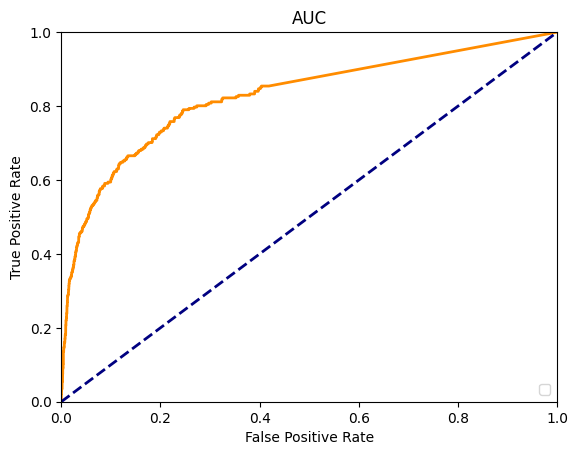

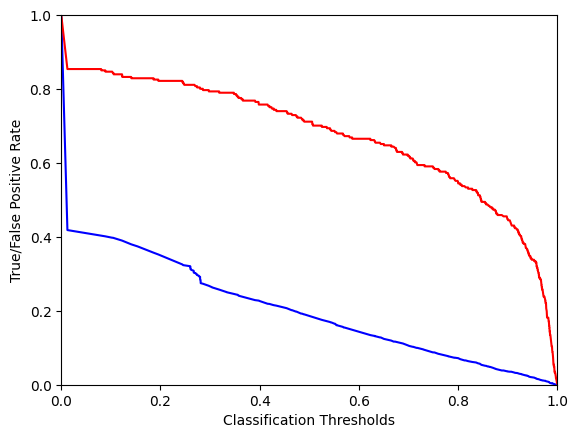

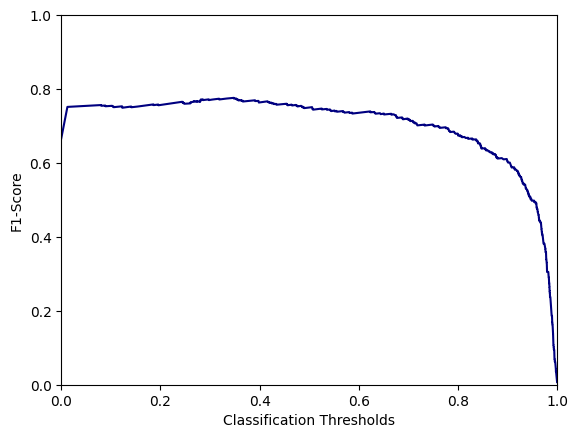

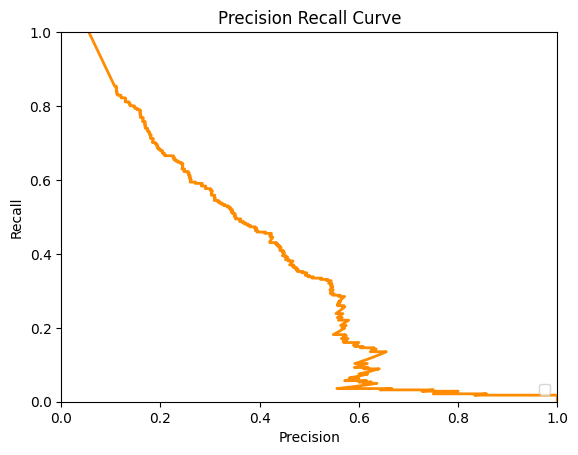

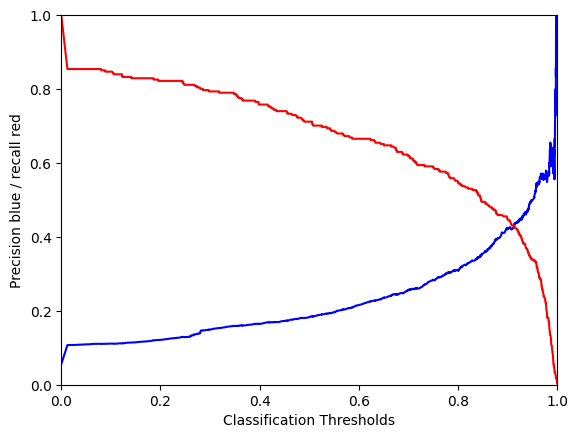

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

num_positives = labels.sum()

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('True/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

length = min(len(precision), len(recall))
plt.figure()
plt.plot(thresholds2, precision[:length-1], color='blue')
plt.plot(thresholds2, recall[:length-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()